In [28]:
from pathlib import Path
from dlfp.common import get_repo_root
ONEMARK_COLLATED_DIR = get_repo_root() / "evaluations/0512-om4/collated"
CHARMARK_COLLATED_DIR = get_repo_root() / "evaluations/ch4/collated"

In [29]:
%matplotlib inline
import json
import itertools
from typing import NamedTuple
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.axes import Axes
from matplotlib.figure import Figure

class Figurable(NamedTuple):
    
    title: str
    train_loss: list[float]
    valid_loss: list[float]
    
    @staticmethod
    def from_file(file: Path, title_map: dict[str, str] = None) -> 'Figurable':
        title_map = title_map or {}
        losses = json.loads(file.read_text())
        title = losses.get('title', file.stem)
        title = title_map.get(title, title)
        return Figurable(title, losses['train'], losses['valid'])


class Arrangeable(NamedTuple):
    
    figurables: np.ndarray
    ylim: tuple[float, float] = None
        

def plot_epochs_curves(arrangeable: Arrangeable, fig_sz_factor_x: float = 2.25, fig_sz_factor_y: float = 2.0):
    arrangement = np.array(arrangeable.figurables, dtype=object)
    print(arrangement.shape)
    if arrangement.ndim == 1:
        arrangement = arrangement.reshape(1, -1)
    assert arrangement.ndim == 2, f"arrangement has shape {arrangement.shape}; must be 2D"
    rows, cols = arrangement.shape
    fig, ax_array = plt.subplots(rows, cols, figsize=(cols * fig_sz_factor_x, rows * fig_sz_factor_y))
    fig: Figure
    # fig.tight_layout()
    ax_array = ax_array.reshape(rows, cols)
    for r, c in itertools.product(range(rows), range(cols)):
        print("plotting", r, c)
        ax: Axes = ax_array[r,c]
        f: Figurable = arrangement[r,c]
        ax.set_title(f.title)
        ax.set_xlabel("Epoch")
        first = r == 0 and c == 0
        if first:
            ax.set_ylabel("Cross-Entropy Loss")
        if c > 0:
            ax.get_yaxis().set_visible(False)
        if arrangeable.ylim:
            ax.set_ylim(*arrangeable.ylim)
        epochs = list(range(max(len(f.train_loss), len(f.valid_loss))))
        generator_loss, discriminator_loss = np.array(f.train_loss), np.array(f.valid_loss)
        ax.plot(epochs, generator_loss, label=f"Train")
        ax.plot(epochs, discriminator_loss, label=f"Valid")
        if first:
            ax.legend()
    plt.show()



(1, 3)
plotting 0 0
plotting 0 1
plotting 0 2


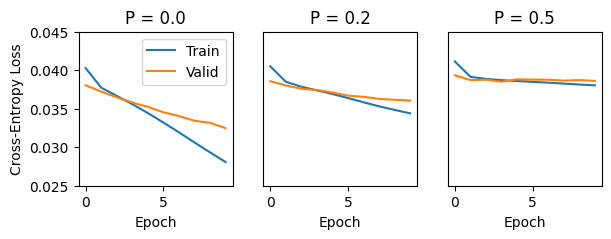

In [30]:
def plot_onemark_dropout():
    filenames = [
        "1-onemark-tdr0.0-losses.json",
        # "6-onemark-default-losses.json", 
        "7-onemark-tdr0.2-losses.json",
        "2-onemark-tdr0.5-losses.json",
    ]
    title_map = {
        "onemark-tdr0.0": "P = 0.0",
        "onemark-default": "P = 0.1",
        "onemark-tdr0.2": "P = 0.2",
        "onemark-tdr0.5": "P = 0.5",
    }
    arrangement_figs = [
        [Figurable.from_file(ONEMARK_COLLATED_DIR / filename, title_map=title_map) for filename in filenames]
    ]
    figurables = np.full(shape=(1, len(filenames)), fill_value=None, dtype=object)
    figurables[:,:] = arrangement_figs
    arrangeable = Arrangeable(figurables, ylim=(0.025, 0.045))
    plot_epochs_curves(arrangeable)

plot_onemark_dropout()

(1, 2)
plotting 0 0
plotting 0 1


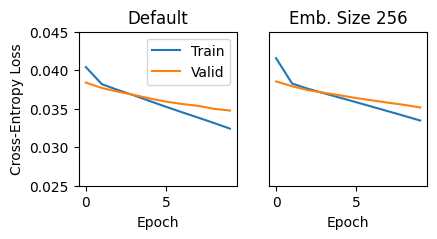

In [31]:
def plot_onemark_default_and_embsize():
    filenames = [
        "6-onemark-default-losses.json", 
        "0-onemark-embsize256-losses.json",
    ]
    title_map = {
        "onemark-default": "Default",
        "onemark-embsize256": "Emb. Size 256",
    }
    arrangement_figs = [
        [Figurable.from_file(ONEMARK_COLLATED_DIR / filename, title_map=title_map) for filename in filenames]
    ]
    figurables = np.full(shape=(1, len(filenames)), fill_value=None, dtype=object)
    figurables[:,:] = arrangement_figs
    arrangeable = Arrangeable(figurables, ylim=(0.025, 0.045))
    plot_epochs_curves(arrangeable)

plot_onemark_default_and_embsize()

(1, 2)
plotting 0 0
plotting 0 1


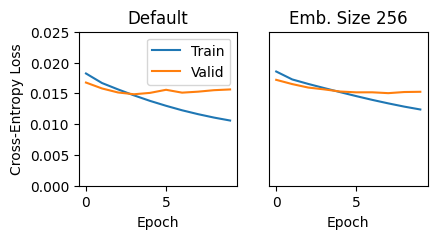

In [32]:
def plot_charmark_default_and_embsize():
    filenames = [
        "1-charmark-default-losses.json", 
        "3-charmark-embsize256-losses.json",
    ]
    title_map = {
        "charmark-default": "Default",
        "charmark-embsize256": "Emb. Size 256",
    }
    arrangement_figs = [
        [Figurable.from_file(CHARMARK_COLLATED_DIR / filename, title_map=title_map) for filename in filenames]
    ]
    figurables = np.full(shape=(1, len(filenames)), fill_value=None, dtype=object)
    figurables[:,:] = arrangement_figs
    arrangeable = Arrangeable(figurables, ylim=(0.0, 0.025))
    plot_epochs_curves(arrangeable)

plot_charmark_default_and_embsize()

(1, 3)
plotting 0 0
plotting 0 1
plotting 0 2


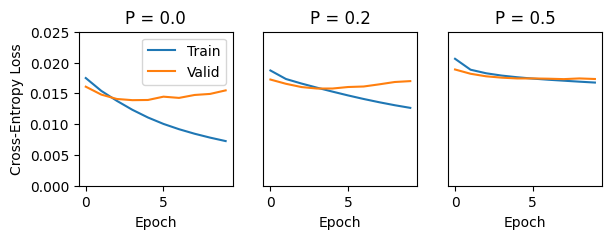

In [33]:
def plot_charmark_dropout():
    filenames = [
        "9-charmark-tdr0.0-losses.json",
        "10-charmark-tdr0.2-losses.json",
        "0-charmark-tdr0.5-losses.json",
    ]
    title_map = {
        "charmark-tdr0.0": "P = 0.0",
        "charmark-tdr0.2": "P = 0.2",
        "charmark-tdr0.5": "P = 0.5",
    }
    arrangement_figs = [
        [Figurable.from_file(CHARMARK_COLLATED_DIR / filename, title_map=title_map) for filename in filenames]
    ]
    figurables = np.full(shape=(1, len(filenames)), fill_value=None, dtype=object)
    figurables[:,:] = arrangement_figs
    arrangeable = Arrangeable(figurables, ylim=(0.0, 0.025))
    plot_epochs_curves(arrangeable)

plot_charmark_dropout()

In [34]:
from typing import Optional
from typing import Collection
import csv
from dlfp.results import measure_accuracy

STRAT_COL = "params/ranks"

class AccuracyLine(NamedTuple):
    
    title: str
    accuracies: dict[int, float]

def parse_files(accuracy_file: Path, baseline_attempts_files: dict[str, Path]) -> list[AccuracyLine]:
    lines = []
    with open(accuracy_file, "r") as ifile:
        reader = csv.DictReader(ifile)
        print(reader.fieldnames)
        ranks = sorted(map(int, set(reader.fieldnames) - {STRAT_COL}))
        for row in reader:
            row: dict[str, str]
            strat = row[STRAT_COL]
            accs = {int(rank):float(row[str(rank)]) for rank in ranks}
            lines.append(AccuracyLine(strat, accs))
    baselines = []
    for baseline_name, baseline_attempts_file in baseline_attempts_files.items():
        baseline_result = measure_accuracy(baseline_attempts_file, ranks=ranks)
        baseline = AccuracyLine(baseline_name, baseline_result.to_proportions())
        baselines.append(baseline)
    lines = baselines + lines
    return lines

def plot_lines(title: Optional[str], 
               lines: list[AccuracyLine], 
               titles: Collection[str] = None, 
               ylim: tuple[float, float] = None, 
               title_map: dict[str, str] = None,
               lmod_disabled: bool = False,
               legend_place: Optional[str] = None):
    title_map = title_map or {}
    print("titles:", [line.title for line in lines])
    if titles:
        lines_by_title = {line.title:line for line in lines}
        lines = [lines_by_title[title] for title in titles]
        print("reordered")
    print("titles:", [line.title for line in lines])
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    fig: Figure
    # fig.tight_layout()
    ax: Axes
    
    ax.set_title(title)
    ax.set_xlabel("Rank")
    ax.set_ylabel("Accuracy (%)")
    ylim = ylim or (0, 100)
    ax.set_ylim(*ylim)
    for line in lines:
        print("plotting", line.title)
        if titles and not line.title in titles:
            continue
        ranks = sorted(line.accuracies.keys())
        accs = [line.accuracies[rank] * 100.0 for rank in ranks]
        lmod = "" if lmod_disabled else "L"
        label = line.title if line.title == "baseline" else f"{lmod}{title_map.get(line.title, line.title)}"
        ax.plot(ranks, accs, label=label)
    if legend_place:
        ax.legend(loc=legend_place)
    else:
        ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

['params/ranks', '1', '10', '20', '30', '40', '50', '60', '70', '80', '90', '100']
titles: ['baseline', '100-10-2', '4', '3', '40-20-10-5', '5', '40-40-20-10', '100-3-2', '2', '40-40-20-10']
reordered
titles: ['baseline', '100-10-2']
plotting baseline
plotting 100-10-2


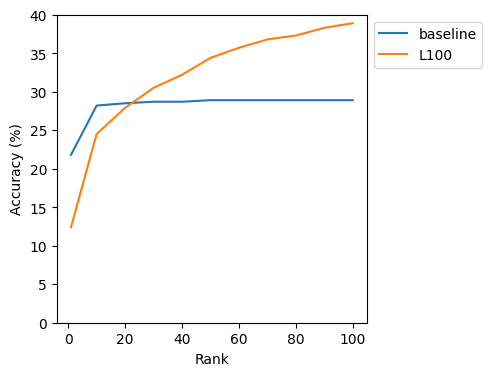

In [35]:


def plot_onemark_acc():
    ONEMARK_BASELINE_FILE = get_repo_root() / "evaluations/cs-attempts-onemark-valid_r98765_s1000-20240513-1356.csv"
    ONEMARK_ACCURACY_FILE = ONEMARK_COLLATED_DIR / "1-onemark-tdr0.0-accuracy.csv"
    lines = parse_files(ONEMARK_ACCURACY_FILE, {"baseline": ONEMARK_BASELINE_FILE})
    plot_lines(None, lines, titles=[
        "baseline", "100-10-2",
    ], ylim=(0, 40), title_map={"100-10-2": "100"})

plot_onemark_acc()

['params/ranks', '1', '10', '20', '30', '40', '50', '60', '70', '80', '90', '100']
titles: ['baseline', '2', '8-8-4-4-2', '12-6-3-2-1', '3', '4', '5']
reordered
titles: ['baseline', '2', '3', '4', '5', '8-8-4-4-2', '12-6-3-2-1']
plotting baseline
plotting 2
plotting 3
plotting 4
plotting 5
plotting 8-8-4-4-2
plotting 12-6-3-2-1


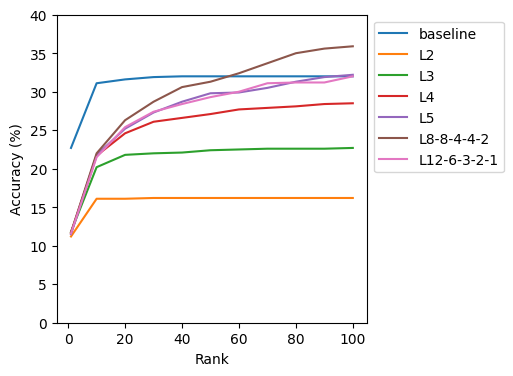

In [36]:


def plot_charmark_acc():
    CHARMARK_BASELINE_FILE = get_repo_root() / "evaluations/cs-attempts-charmark-valid_r654_s1000-20240513-1402.csv"
    CHARMARK_ACCURACY_FILE = CHARMARK_COLLATED_DIR / "3-charmark-embsize256-accuracy.csv"
    lines = parse_files(CHARMARK_ACCURACY_FILE, {"baseline": CHARMARK_BASELINE_FILE})
    plot_lines(None, lines, titles=[
        "baseline", "2", "3", "4", "5", "8-8-4-4-2", "12-6-3-2-1", 
    ], ylim=(0, 40))

plot_charmark_acc()

titles: ['baseline-word', 'baseline-letter', 'word-L100', 'letter-L5']
titles: ['baseline-word', 'baseline-letter', 'word-L100', 'letter-L5']
plotting baseline-word
plotting baseline-letter
plotting word-L100
plotting letter-L5


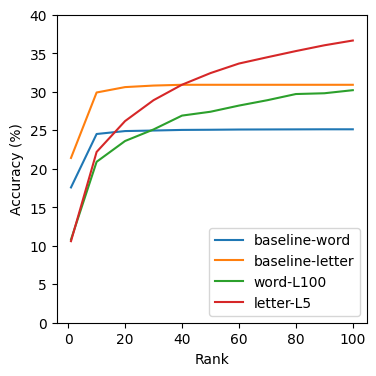

In [37]:


def show_test_results():
    charmark_baseline_test_attempts_file = get_repo_root() / "evaluations" / "cs-attempts-charmark-test_r5678_s1000_t5-20240513-1727.csv"
    onemark_baseline_test_attempts_file = get_repo_root() / "evaluations" / "cs-attempts-onemark-test_r5678_s10000-20240513-1810.csv"
    onemark_model_attempts_file = get_repo_root() / "evaluations" / "onemark-checkpoint-epoch009_test_r5678_s10000_20240513-172043.csv"
    charmark_model_attempts_file = get_repo_root() / "evaluations" / "charmark-checkpoint-epoch009_test_r5678_s1000_t5_20240513-172424.csv"
    files_by_title = {
        "baseline-word": onemark_baseline_test_attempts_file,
        "baseline-letter": charmark_baseline_test_attempts_file,
        "word-L100": charmark_model_attempts_file,
        "letter-L5": onemark_model_attempts_file,
    }
    lines = [AccuracyLine(title, measure_accuracy(file).to_proportions()) for title, file in files_by_title.items()]
    plot_lines(None, lines, ylim=(0,40), lmod_disabled=True, legend_place="lower right")
    
show_test_results()

(1, 5)
plotting 0 0
plotting 0 1
plotting 0 2
plotting 0 3
plotting 0 4


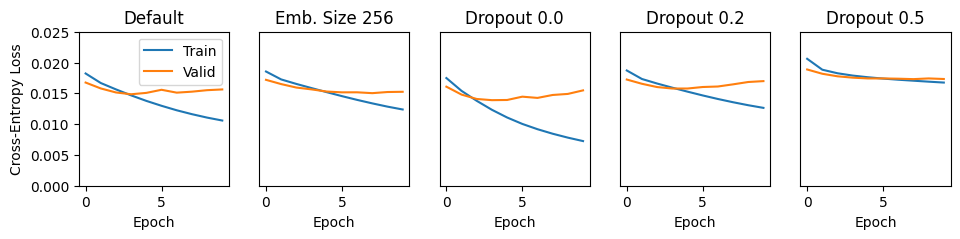

In [38]:
def plot_charmark_all():
    filenames = [
        "1-charmark-default-losses.json", 
        "3-charmark-embsize256-losses.json",
        "9-charmark-tdr0.0-losses.json",
        "10-charmark-tdr0.2-losses.json",
        "0-charmark-tdr0.5-losses.json",
    ]
    title_map = {
        "charmark-default": "Default",
        "charmark-embsize256": "Emb. Size 256",
        "charmark-tdr0.0": "Dropout 0.0",
        "charmark-tdr0.2": "Dropout 0.2",
        "charmark-tdr0.5": "Dropout 0.5",
    }
    arrangement_figs = [
        [Figurable.from_file(CHARMARK_COLLATED_DIR / filename, title_map=title_map) for filename in filenames]
    ]
    figurables = np.full(shape=(1, len(filenames)), fill_value=None, dtype=object)
    figurables[:,:] = arrangement_figs
    arrangeable = Arrangeable(figurables, ylim=(0.0, 0.025))
    plot_epochs_curves(arrangeable)

plot_charmark_all()

(1, 5)
plotting 0 0
plotting 0 1
plotting 0 2
plotting 0 3
plotting 0 4


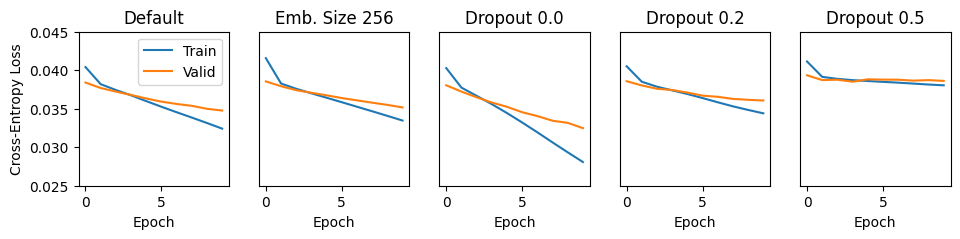

In [39]:
def plot_onemark_all():
    filenames = [
        "6-onemark-default-losses.json", 
        "0-onemark-embsize256-losses.json",
        "1-onemark-tdr0.0-losses.json",
        "7-onemark-tdr0.2-losses.json",
        "2-onemark-tdr0.5-losses.json",
    ]
    title_map = {
        "onemark-default": "Default",
        "onemark-embsize256": "Emb. Size 256",
        "onemark-tdr0.0": "Dropout 0.0",
        "onemark-tdr0.2": "Dropout 0.2",
        "onemark-tdr0.5": "Dropout 0.5",
    }
    arrangement_figs = [
        [Figurable.from_file(ONEMARK_COLLATED_DIR / filename, title_map=title_map) for filename in filenames]
    ]
    figurables = np.full(shape=(1, len(filenames)), fill_value=None, dtype=object)
    figurables[:,:] = arrangement_figs
    arrangeable = Arrangeable(figurables, ylim=(0.025, 0.045))
    plot_epochs_curves(arrangeable)

plot_onemark_all()